# NeuroVec 

In [8]:
import NLP_Preprocessor as nlp
import re 

import wikipediaapi

import glob
import pickle

import time

## Download dataset methods

In [5]:
stopLinks = ["BBC"]

In [11]:
wiki = wikipediaapi.Wikipedia('en')

def getLinks(title, layer, maxLayer,allTitles):
    if layer <= maxLayer: # if its not the max layer
        global stopLinks
        if title not in allTitles and title not in stopLinks: # if it has not already been seen
            allTitles[title] = 0 # add to dict of seen titles
            if layer != maxLayer:
                wikiPage = wiki.page(title) #get page
                if len(wikiPage.links) > 500:
                    print(len(wikiPage.links),"\t",title)
                for link in wikiPage.links: # for each link
                    allTitles = getLinks(link,layer + 1,maxLayer,allTitles) # recurse
    return allTitles
    
def getWikiTitles(title,saveLocation,allTitles, maxLayer):
    
    #getLinks
    allTitles = getLinks(title, 0, maxLayer, allTitles)
    return allTitles


def downloadWikiData(allTitles,pagesPerFile = 100):
    rawText = ""
    for i,title in enumerate(allTitles.keys()):
        #get the wikipage text
        wikiPage = wiki.page(title)
        rawText += wikiPage.text.replace("\n","") + "\n"
        
        #save the file
        if i % pagesPerFile == 0:
            print(i,len(rawText))
            file = open("../Data/WikiData/" + str(i) + ".txt","w",encoding="utf-8")#saveLocation+title.replace(" ","_")+".txt", 'w')
            file.write(rawText.replace("\n"," "))
            file.close()
            rawText = ""
            
    print("Final save")
    file = open("../Data/WikiData/final.txt","w",encoding="utf-8")#saveLocation+title.replace(" ","_")+".txt", 'w')
    file.write(rawText.replace("\n"," "))
    file.close()

## Downloading dataset

In [12]:
seedPages = ["Neuroscience".title(),"Action potential".title(),"Brain damage".title(),"Brain imaging".title(),"Brain science".title(),"Brain".title()]

maxLayer = 2
allTitles = dict()
for page in seedPages:
    print(page)
    allTitles = getWikiTitles(page,"../Data/WikiData/",allTitles,maxLayer)

print(len(allTitles))

downloadWikiData(allTitles)


Neuroscience
1225 	 Abiogenesis
930 	 Ancient Egypt
1081 	 Australia
994 	 Austria
697 	 Bat
707 	 Biological Sciences
530 	 Biopsychology
Action Potential
Brain Damage
Brain Imaging
Brain Science
Brain
9649


# Word vector methods

In [16]:
import WordEmbeddingGenerator as weg

## Read dataset from files

In [45]:
def getWordSentencesFromDocument(filename):
    file = open(filename,"r",encoding="utf-8")#saveLocation+title.replace(" ","_")+".txt", 'w')
    rawText = file.read()
    file.close()
    rawText = rawText.lower()
    #loading and cleansing data
    START_TOKEN = 'START '
    END_TOKEN = ' END'

    #rHTMLtext = re.sub("\\[[0-9]+]" , " ", rawText)
    rHTMLtext = re.sub("—" , "-", rawText)
    # replacing numbers
    text = nlp.numberReplacer(rHTMLtext,replaceString=" NUMBERS ")
    #splitting out sentences
    sentences = nlp.sentenceSplit(text)
    #adding start and end token
    sentences = [START_TOKEN + s + END_TOKEN for s in sentences]
    #removing symbols
    sentences = [nlp.symbolReplacer(s,extraChars="-",replaceString=" ") for s in sentences]
    #splitting out words
    wordSentences = [nlp.wordSplit(sentence) for sentence in sentences]
    #removing stop words
    wordSentences = [nlp.removeStopWords(sentence) for sentence in wordSentences]
    #lemmatizing words
    wordSentences = [nlp.lemmatizeWords(sent) for sent in wordSentences]
    return wordSentences


files = glob.glob("../Data/WikiData/*")
for file in files:
    t0 = time.time()
    print("Starting:",file)
    wordSentences = getWordSentencesFromDocument(file)
    
    with open("../Data/WikiDataProcessed/"+file.split("\\")[-1].split(".")[0]+".pkl", 'wb') as f:
        pickle.dump(wordSentences, f)
    
    t1 = time.time()
    total = t1-t0
    print("Finished:", total)
print("done")


Starting: ../Data/WikiData\0.txt
Finished: 1.600327491760254
Starting: ../Data/WikiData\100.txt
Finished: 107.71434783935547
Starting: ../Data/WikiData\1000.txt
Finished: 131.63911604881287
Starting: ../Data/WikiData\1100.txt
Finished: 118.83508443832397
Starting: ../Data/WikiData\1200.txt
Finished: 164.77854537963867
Starting: ../Data/WikiData\1300.txt
Finished: 41.35242438316345
Starting: ../Data/WikiData\1400.txt
Finished: 125.95520782470703
Starting: ../Data/WikiData\1500.txt
Finished: 94.99117159843445
Starting: ../Data/WikiData\1600.txt
Finished: 138.43317699432373
Starting: ../Data/WikiData\1700.txt
Finished: 45.038585901260376
Starting: ../Data/WikiData\1800.txt
Finished: 112.24390196800232
Starting: ../Data/WikiData\1900.txt
Finished: 114.92317056655884
Starting: ../Data/WikiData\200.txt
Finished: 133.84120345115662
Starting: ../Data/WikiData\2000.txt
Finished: 119.8510103225708
Starting: ../Data/WikiData\2100.txt
Finished: 116.6995358467102
Starting: ../Data/WikiData\2200.txt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

wordSentences = []
files = glob.glob("../Data/WikiDataProcessed/*")
for file in files[:5]:
    print(file)
    with open(file, 'rb') as f:
        x = pickle.load(f)
        wordSentences.extend(x)

#creating vectors
M_co_occurrence, word2Ind_co_occurrence = weg.compute_co_occurrence_matrix(wordSentences)

M_reduced_co_occurrence = weg.reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
words = list(word2Ind_co_occurrence.keys())[0:30]
weg.plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

# Word2Vec

In [94]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from sklearn.cluster import KMeans

In [27]:
wordSentences = []
files = glob.glob("../Data/WikiDataProcessed/*")

#load in all files
for file in files:
    print(file)
    with open(file, 'rb') as f:
        x = pickle.load(f)
        wordSentences.extend(x)

print("-----------------")
print("Files loaded")
print("-----------------")


# train model
model = Word2Vec(wordSentences, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(len(words))
# access vector for one word
print(model['neuroscience'])
print("Saving word")
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print("Done")

../Data/WikiDataProcessed\0.pkl
../Data/WikiDataProcessed\100.pkl
../Data/WikiDataProcessed\1000.pkl
../Data/WikiDataProcessed\1100.pkl
../Data/WikiDataProcessed\1200.pkl
../Data/WikiDataProcessed\1300.pkl
../Data/WikiDataProcessed\1400.pkl
../Data/WikiDataProcessed\1500.pkl
../Data/WikiDataProcessed\1600.pkl
../Data/WikiDataProcessed\1700.pkl
../Data/WikiDataProcessed\1800.pkl
../Data/WikiDataProcessed\1900.pkl
../Data/WikiDataProcessed\200.pkl
../Data/WikiDataProcessed\2000.pkl
../Data/WikiDataProcessed\2100.pkl
../Data/WikiDataProcessed\2200.pkl
../Data/WikiDataProcessed\2300.pkl
../Data/WikiDataProcessed\2400.pkl
../Data/WikiDataProcessed\2500.pkl
../Data/WikiDataProcessed\2600.pkl
../Data/WikiDataProcessed\2700.pkl
../Data/WikiDataProcessed\2800.pkl
../Data/WikiDataProcessed\2900.pkl
../Data/WikiDataProcessed\300.pkl
../Data/WikiDataProcessed\3000.pkl
../Data/WikiDataProcessed\3100.pkl
../Data/WikiDataProcessed\3200.pkl
../Data/WikiDataProcessed\3300.pkl
../Data/WikiDataProcessed\

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Done


In [20]:
new_model = Word2Vec.load('model.bin')
new_model.wv.most_similar('neuroscience')

C:\Users\Christian\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('neurobiology', 0.8152838945388794),
 ('biology', 0.7514864206314087),
 ('integrative', 0.7447909116744995),
 ('biophysics', 0.7306403517723083),
 ('immunology', 0.7298644781112671),
 ('microbiology', 0.7219469547271729),
 ('neuroendocrinology', 0.7213983535766602),
 ('neuropsychology', 0.7202700972557068),
 ('neuroanatomy', 0.715740978717804),
 ('psychology', 0.7109661102294922)]

In [136]:
#man : king :: woman : x
#pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))
#new_model.most_similar(positive=["rna","deoxyribonucleotide"], negative=["dna"])
new_model.most_similar('cancer')

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
C:\Users\Christian\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('leukemia', 0.707366406917572),
 ('lymphoma', 0.7015130519866943),
 ('adenocarcinoma', 0.6902438998222351),
 ('anemia', 0.6882880330085754),
 ('disease', 0.6853922009468079),
 ('melanoma', 0.6839083433151245),
 ('tumor', 0.6826170682907104),
 ('non-hodgkin', 0.675466001033783),
 ('tuberculosis', 0.6659038066864014),
 ('tumour', 0.6652096509933472)]

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


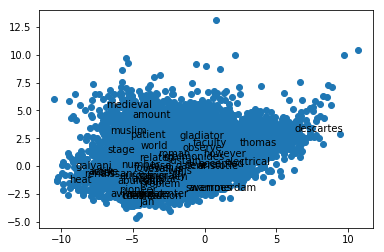

In [57]:


# fit a 2d PCA model to the vectors
X = new_model[new_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(new_model.wv.vocab)
for i, word in enumerate(words[150:200]):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


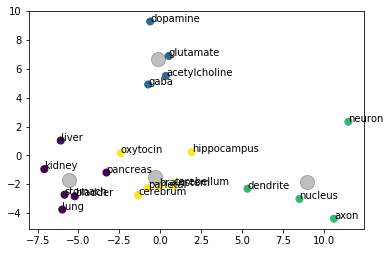

In [119]:
neurotransmitters = ['dopamine','acetylcholine','glutamate','gaba','oxytocin']
partsOfNeuron = ['dendrite','axon','neuron','nucleus']
partsOfBody = ['lung','kidney','stomach','bladder','pancreas','liver']
partsOfBrain = ['cerebrum','cerebellum','brainstem','parietal','hippocampus']

words = neurotransmitters + partsOfBody + partsOfBrain + partsOfNeuron
numGroups = 4

# fit a 2d PCA model to the vectors
X = new_model[words]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

kmeans = KMeans(n_clusters=numGroups, random_state=1).fit(result)

# create a scatter plot of the projection
y_kmeans = kmeans.predict(result)
plt.scatter(result[:, 0], result[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.25);    

for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [105]:
#calculating average similarity index for top 10 most similar words
words = list(new_model.wv.vocab)


numWords = 10000
topN = 1
array = np.zeros(numWords*topN)

#top 10
#.752 mean
#.1 std

#top 3
#.777 mean
#.097 std

#top 1
# mean
# std
count = 0
cutOff = .62
for i, word in enumerate(words[:numWords]):
    similarWords = [word[1] for word in new_model.most_similar(word)]
    for w in range(0,topN):
        array[i*topN+w] = similarWords[w]
    if similarWords[0] > cutOff:
        count +=1
print(array.mean())
print(array.std())
print(count,numWords,float(count/numWords))

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
C:\Users\Christian\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.7845723679959774
0.09306095669763831
9504 10000 0.9504


In [137]:
import networkx as nx

cutOff = .62
#instantiating graph
G = nx.DiGraph()
words = list(new_model.wv.vocab)
print("Words to complete:",len(words))
t0 = time.time()
for i, word in enumerate(words):
    for w in new_model.most_similar(word):
        if w[1] > cutOff:
            G.add_edge(word,w[0])
    if i % 25000 == 0:
        t1 = time.time()
        total = t1-t0
        print(i, "finished:", total)
t1 = time.time()
total = t1-t0
print("Finished:", total)

Words to complete: 359544
0 finished: 0.012965917587280273


C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Christian\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


25000 finished: 300.19369292259216
50000 finished: 601.5955300331116
75000 finished: 901.1603078842163
100000 finished: 1199.6700093746185
125000 finished: 1499.086210489273
150000 finished: 1802.0755140781403
175000 finished: 2099.855563402176
200000 finished: 2397.075653553009
225000 finished: 2693.831305742264
250000 finished: 2991.678254365921
275000 finished: 3289.719118118286
300000 finished: 3586.9615936279297
325000 finished: 3882.887644290924
350000 finished: 4179.349249839783
Finished: 4292.849670171738


In [138]:
G.remove_edges_from(G.selfloop_edges())
duplicates = [(node, node + "s") for node in G if node + "s" in G]
for dup in duplicates:
    G = nx.contracted_nodes(G, *dup, self_loops=False)
duplicates = [(x, y) for x, y 
              in [(node, node.replace("-", " ")) for node in G]
              if x != y and y in G]
for dup in duplicates:
    G = nx.contracted_nodes(G, *dup, self_loops=False)
nx.set_node_attributes(G, 0, "contraction")

In [142]:
core = [node for node, deg in dict(G.degree()).items() if deg >= 50]
G2 = nx.subgraph(G, core)
print("{} nodes, {} edges".format(len(G2), nx.number_of_edges(G2)))
# 2995 nodes, 11817 edges
nx.write_graphml(G2, "../Data/graphFile_Neuroscience_Deg_greaterthan_50.graphml")

14664 nodes, 125529 edges
